In [1]:
!pip install tensorflow-addons==0.16.1


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 40.6 MB/s eta 0:00:00


In [2]:
from tensorflow.keras import layers
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import tensorflow as tf
import numpy as np
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.6.0 and strictly below 2.9.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.12.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import json
import math
import os

import cv2
import pywt
from PIL import Image
import numpy as np
from keras import layers
#from keras.applications import ResNet50,MobileNet, DenseNet201, InceptionV3, NASNetLarge, InceptionResNetV2, NASNetMobile
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
#from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import BatchNormalization
from sklearn.model_selection import KFold



%matplotlib inline

In [5]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 16
num_epochs = 100
num_heads= 4
projection_dim = 64

In [6]:
from sklearn.utils import shuffle
from skimage import color

In [7]:
def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)
    imArray /= 255;
    # compute coefficients
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)
    coeffs_H[0] *= 0;

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

In [8]:
def get_images(directory):
    Images = []
    Labels = []  # 0 for BENIGN, 1 for MALIGNANT
    label = 0

    for labels in os.listdir(directory):
        if labels == 'benign':
            label = 0
        elif labels == 'malignant':
            label = 1

        for image_file in os.listdir(directory+labels):
            image = cv2.imread(directory+labels+r'/'+image_file)
            #image = color.rgb2gray(image)
            image = cv2.resize(image,(32,32,))
            wv_trans_img = w2d(image, 'db1', 1)
            wv_trans_img_har = cv2.resize(wv_trans_img, (32, 32,))
            combined_img = np.vstack((image.reshape(32*32*3,1), wv_trans_img_har.reshape(32*32,1)))
            Images.append(image)
            Labels.append(label)

    return shuffle(Images,Labels,random_state=11)

def get_classlabel(class_code):
    labels = {0:'benign', 1:'malignant'}

    return labels[class_code]

In [9]:
X,Y = get_images('/content/drive/MyDrive/dataset/Augmented Images 4/')
X= np.array(X)
Y= np.array(Y)

In [10]:
X.shape

(1948, 32, 32, 3)

In [11]:
image_size = 32
auto = tf.data.AUTOTUNE

data_augmentation = keras.Sequential(
    [layers.RandomCrop(image_size, image_size), layers.RandomFlip("horizontal"),],
    name="data_augmentation",
)

def make_datasets(images, labels):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    dataset = dataset.shuffle(batch_size * 10)
    dataset = dataset.batch(batch_size)
    return dataset.prefetch(auto)

In [12]:
def fire_module(x, squeeze_channels, expand1x1_channels, expand3x3_channels):
    squeeze = layers.Conv2D(squeeze_channels, (1, 1), activation='relu')(x)
    expand1x1 = layers.Conv2D(expand1x1_channels, (1, 1), activation='relu')(squeeze)
    expand3x3 = layers.Conv2D(expand3x3_channels, (3, 3), padding='same', activation='relu')(squeeze)
    return layers.Concatenate()([expand1x1, expand3x3])

In [13]:

def activation_block(x):
    x = layers.Activation("gelu")(x)
    return layers.BatchNormalization()(x)


def conv_stem(x, filters: int, patch_size: int):
    x = layers.Conv2D(filters, kernel_size=patch_size, strides=patch_size)(x)
#     x = layers.Flatten()(x)
    return activation_block(x)


def conv_mixer_block(x, filters: int, kernel_size: int):
    # Depthwise convolution.
    x0 = x
    x = layers.DepthwiseConv2D(kernel_size=kernel_size, padding="same")(x)
    x = fire_module(x, 16, 128, 128)
    x = layers.Add()([activation_block(x), x0])  # Residual.
    x1 = x

    # Pointwise convolution.
    x = layers.Conv2D(filters, kernel_size=1)(x)
    # x = fire_module(x, 16, 128, 128)
    # x = activation_block(x)
    x = layers.Add()([activation_block(x), x1])  # Residual.
    # x = layers.Add()([activation_block(x), x0])  # Residual.

    return x


def get_conv_mixer_256_8(
    image_size=32, filters=256, depth=8, kernel_size=5, patch_size=2, num_classes=1
):
    """ConvMixer-256/8: https://openreview.net/pdf?id=TVHS5Y4dNvM.
    The hyperparameter values are taken from the paper.
    """
    inputs = keras.Input((image_size, image_size, 3))
    x = layers.Rescaling(scale=1.0 / 255)(inputs)

    # Extract patch embeddings.
    x = conv_stem(x, filters, patch_size)

    # ConvMixer blocks.
    for _ in range(depth):
        x = conv_mixer_block(x, filters, kernel_size)


    # Classification block.
    x = layers.GlobalAvgPool2D()(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    return keras.Model(inputs, outputs)

In [14]:
model=get_conv_mixer_256_8()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 rescaling (Rescaling)          (None, 32, 32, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 16, 16, 256)  3328        ['rescaling[0][0]']              
                                                                                                  
 activation (Activation)        (None, 16, 16, 256)  0           ['conv2d[0][0]']                 
                                                                                              

In [15]:
from sklearn.metrics import precision_score, recall_score

k = 5  # Number of folds for k-fold cross-validation
kf = KFold(n_splits=k, shuffle=True, random_state=11)

all_y_true = []
all_y_pred = []
all_y_pred_probs = []
all_loss = []

accuracy_scores = []
precision_scores = []
recall_scores = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]

    x_train, x_val, y_train, y_val = train_test_split(
        X_train, Y_train,
        test_size=0.2,
        random_state=11
    )

    train_dataset = make_datasets(x_train, y_train)
    val_dataset = make_datasets(x_val, y_val)
    test_dataset = make_datasets(X_test, Y_test)

    model = get_conv_mixer_256_8()
    optimizer = tf.keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=["accuracy"],
    )

    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=num_epochs,
        verbose=1
    )

    # Evaluate on the test dataset
    x_test = X_test  # Define your test data (e.g., X_test)
    y_test = Y_test  # Define your test labels (e.g., Y_test)

    y_pred_probs = model.predict(x_test)
    y_pred = np.round(y_pred_probs).flatten()

    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)
    all_y_pred_probs.extend(y_pred_probs)
    all_loss.append(history.history['loss'][-1])

    accuracy_scores.append(accuracy_score(y_test, y_pred))
    precision_scores.append(precision_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))

Epoch 1/100
78/78 [==============================] - 40s 67ms/step - loss: 1.0301 - accuracy: 0.5417 - val_loss: 1.0279 - val_accuracy: 0.4679
Epoch 2/100
78/78 [==============================] - 3s 41ms/step - loss: 0.7434 - accuracy: 0.5586 - val_loss: 0.8407 - val_accuracy: 0.4679
Epoch 3/100
78/78 [==============================] - 3s 43ms/step - loss: 0.7487 - accuracy: 0.5626 - val_loss: 2.2701 - val_accuracy: 0.4679
Epoch 4/100
78/78 [==============================] - 3s 39ms/step - loss: 0.6878 - accuracy: 0.6043 - val_loss: 1.5584 - val_accuracy: 0.4679
Epoch 5/100
78/78 [==============================] - 3s 44ms/step - loss: 0.6505 - accuracy: 0.6485 - val_loss: 0.8586 - val_accuracy: 0.4808
Epoch 6/100
78/78 [==============================] - 3s 40ms/step - loss: 0.6163 - accuracy: 0.6782 - val_loss: 1.2979 - val_accuracy: 0.4647
Epoch 7/100
78/78 [==============================] - 3s 40ms/step - loss: 0.5916 - accuracy: 0.6910 - val_loss: 0.8314 - val_accuracy: 0.5256
Epoch

In [25]:
# Calculate average metrics
avg_accuracy = np.mean(accuracy_scores)
avg_precision = np.mean(precision_scores)
avg_recall = np.mean(recall_scores)
avg_loss = np.mean(all_loss)

In [27]:
from sklearn.metrics import roc_curve, auc
# Compute average ROC curve
fpr, tpr, thresholds = roc_curve(all_y_true, all_y_pred_probs)
roc_auc = auc(fpr, tpr)

In [29]:
from sklearn.metrics import confusion_matrix
# Compute average confusion matrix
cm = confusion_matrix(all_y_true, all_y_pred)

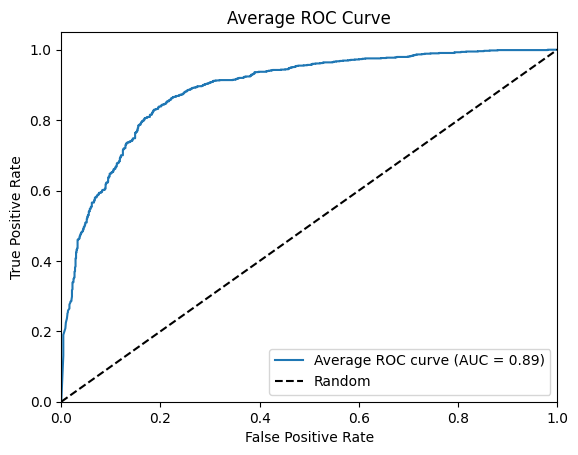

In [30]:
# Plot average ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f"Average ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Average ROC Curve')
plt.legend(loc="lower right")
plt.show()

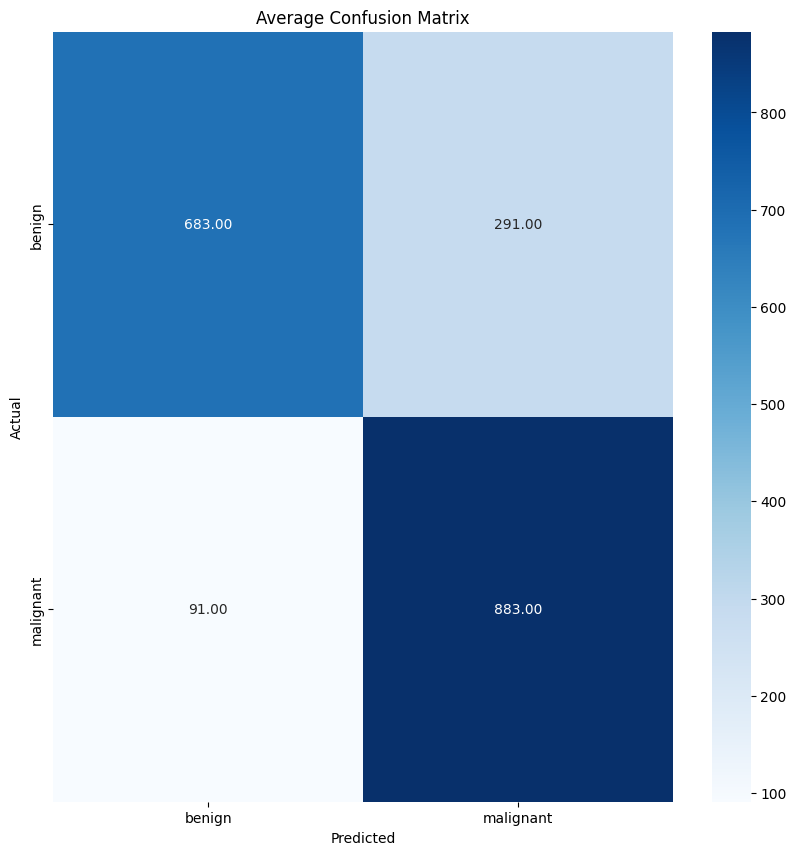

In [32]:
import seaborn as sns
# Plot average confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=["benign", "malignant"],
            yticklabels=["benign", "malignant"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Average Confusion Matrix")
plt.show()

In [33]:
print(f"Average Accuracy: {avg_accuracy:.4f}")
print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average Loss: {avg_loss:.4f}")

Average Accuracy: 0.8039
Average Precision: 0.7586
Average Recall: 0.9076
Average Loss: 0.0447
